**Here we implemented a pulse-level crosstalk attack simulation against the BB84 quantum key distribution protocol.**


--- Running BB84 for Cosine pulse ---
N=100, Pulse=Cosine, Sifted=52, QBER=0.4038
N=250, Pulse=Cosine, Sifted=134, QBER=0.3134
N=500, Pulse=Cosine, Sifted=266, QBER=0.2932
N=700, Pulse=Cosine, Sifted=369, QBER=0.3117

--- Running BB84 for Gaussian pulse ---
N=100, Pulse=Gaussian, Sifted=52, QBER=0.3462
N=250, Pulse=Gaussian, Sifted=134, QBER=0.2761
N=500, Pulse=Gaussian, Sifted=266, QBER=0.2519
N=700, Pulse=Gaussian, Sifted=369, QBER=0.2575

--- Running BB84 for Square pulse ---
N=100, Pulse=Square, Sifted=52, QBER=0.3654
N=250, Pulse=Square, Sifted=134, QBER=0.2836
N=500, Pulse=Square, Sifted=266, QBER=0.2594
N=700, Pulse=Square, Sifted=369, QBER=0.2710

--- Running BB84 for Chirp pulse ---
N=100, Pulse=Chirp, Sifted=52, QBER=0.3462
N=250, Pulse=Chirp, Sifted=134, QBER=0.2761
N=500, Pulse=Chirp, Sifted=266, QBER=0.2519
N=700, Pulse=Chirp, Sifted=369, QBER=0.2575

--- Running BB84 for DRAG pulse ---
N=100, Pulse=DRAG, Sifted=52, QBER=0.0577
N=250, Pulse=DRAG, Sifted=134, QBER=0.0373
N

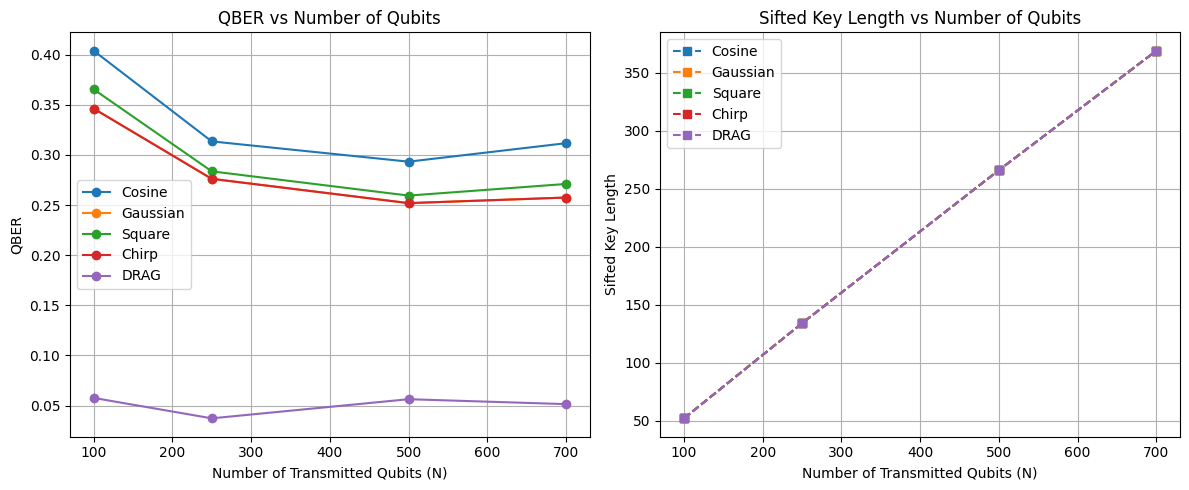

In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmay, sigmaz, qeye, mesolve

# ---- BB84 state definitions (Alice)
state_0 = basis(2,0)         # |0>
state_1 = basis(2,1)         # |1>
state_plus = (basis(2,0)+basis(2,1)).unit()  # |+>
state_minus = (basis(2,0)-basis(2,1)).unit() # |->

def pulse_cosine(t, A=1.0, delta=0.0, **kwargs):
    return A * np.cos(delta * t)

def pulse_gaussian(t, A=1.0, sigma=0.08, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

def pulse_square(t, A=1.0, **kwargs):
    return A if 0.3 < t <= 0.7 else 0.0

def pulse_chirp(t, A=1.0, delta=0.0, c=5.0, **kwargs):
    return A * np.cos((delta + c*t) * t)

def pulse_drag(t, A=1.0, sigma=0.08, alpha=2.0, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2)) - alpha * ((t - 0.5)**2) / (sigma**2)

pulse_shapes = {
    "Cosine": pulse_cosine,
    "Gaussian": pulse_gaussian,
    "Square": pulse_square,
    "Chirp": pulse_chirp,
    "DRAG": pulse_drag
}

# projectors for measurement
P0 = state_0*state_0.dag()
P1 = state_1*state_1.dag()
Pplus = state_plus*state_plus.dag()
Pminus = state_minus*state_minus.dag()

def evolve_three_qubit(state_q2, pulse_func, A=1.0, delta=0.0):
    """
    Evolve 3-qubit system under the same Hamiltonian with Eve’s pulse drives.
    Returns the reduced density matrix of Alice's qubit q2.
    """

    # Example constants (you can adjust)
    J01, J12 = 1.0, 1.0
    X, Y, Z, I = sigmax(), sigmay(), sigmaz(), qeye(2)
    n_steps = 50
    tlist = np.linspace(0, 1, n_steps)

    # Build Hamiltonian
    H_coup_01 = tensor(Y, X, I)
    H_coup_12 = tensor(I, Z, X)

    # Drive terms (Eve injecting pulse on qubit 0 and 1)
    H_drive_0 = [tensor(X, I, I), lambda t, args: pulse_func(t, A=A, delta=delta)]
    H_drive_1 = [tensor(I, X, I), lambda t, args: pulse_func(t, A=A, delta=delta)]

    # Total Hamiltonian (static + time-dependent)
    H = [J01 * H_coup_01 + J12 * H_coup_12, H_drive_0, H_drive_1]

    # Initial state: |0,0,ψ_Alice⟩
    psi0 = tensor(basis(2,0), basis(2,0), state_q2)

    # Solve Schrödinger equation
    result = mesolve(H, psi0, tlist, [], [])
    final_state = result.states[-1]

    # Return reduced density matrix of Alice’s qubit (q2)
    return final_state.ptrace(2)


# reuse pulse shapes and evolve_three_qubit with same H (drives + couplings)
def measure_bb84(rho, basis_choice):
    """basis_choice: 0=Z, 1=X; returns measured bit 0/1"""
    if basis_choice == 0:  # Z basis
        p0 = np.real((P0 * rho).tr())
        return 0 if random.random() < p0 else 1
    else:  # X basis
        pplus = np.real((Pplus * rho).tr())
        return 0 if random.random() < pplus else 1

def run_bb84(N=500, pulse_func=pulse_gaussian, A=1.0, delta=0.0, seed=42):
    random.seed(seed)
    alice_bits, alice_bases, bob_bases, bob_results = [], [], [], []
    for _ in range(N):
        bit = random.randint(0,1)
        basis = random.randint(0,1)  # 0=Z,1=X for preparation
        # prepare state
        if basis == 0:
            state = state_0 if bit == 0 else state_1
        else:
            state = state_plus if bit == 0 else state_minus
        alice_bits.append(bit)
        alice_bases.append(basis)

        # evolve under same 3-qubit Hamiltonian (Eve drives)
        rho_q2 = evolve_three_qubit(state, pulse_func, A=A, delta=delta)

        # Bob chooses measurement basis randomly
        bob_basis = random.randint(0,1)
        bob_bases.append(bob_basis)
        bob_results.append(measure_bb84(rho_q2, bob_basis))

    # Sifting: keep rounds where preparation basis == measurement basis
    sift_a, sift_b = [], []
    for a_bit, a_basis, b_res, b_basis in zip(alice_bits, alice_bases, bob_results, bob_bases):
        if a_basis == b_basis:
            sift_a.append(a_bit)
            sift_b.append(b_res)
    # QBER
    mismatches = sum(a != b for a, b in zip(sift_a, sift_b))
    qber = mismatches / len(sift_a) if sift_a else 0.0
    return qber, len(sift_a)

# ===============================
# Multi-Pulse Comparison for BB84
# ===============================

N_values = [100, 250, 500, 700]

# Storage for results
results_qber = {}
results_sift = {}

# Loop through all pulse shapes
for chosen_shape, pulse_func in pulse_shapes.items():
    print(f"\n--- Running BB84 for {chosen_shape} pulse ---")
    qbers, sift_lengths = [], []

    for N in N_values:
        qber, sift_len = run_bb84(N=N, pulse_func=pulse_func, A=1.0, delta=0.0, seed=42)
        qbers.append(qber)
        sift_lengths.append(sift_len)
        print(f"N={N}, Pulse={chosen_shape}, Sifted={sift_len}, QBER={qber:.4f}")

    # ✅ Store results correctly
    results_qber[chosen_shape] = qbers
    results_sift[chosen_shape] = sift_lengths

# =====================================
# Plotting: QBER and Sifted Key Length
# =====================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- QBER vs N ---
for shape, qbers in results_qber.items():
    axes[0].plot(N_values, qbers, 'o-', label=shape)
axes[0].set_title("QBER vs Number of Qubits")
axes[0].set_xlabel("Number of Transmitted Qubits (N)")
axes[0].set_ylabel("QBER")
axes[0].grid(True)
axes[0].legend()

# --- Sifted Key Length vs N ---
for shape, sifts in results_sift.items():
    axes[1].plot(N_values, sifts, 's--', label=shape)
axes[1].set_title("Sifted Key Length vs Number of Qubits")
axes[1].set_xlabel("Number of Transmitted Qubits (N)")
axes[1].set_ylabel("Sifted Key Length")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

**BB84 pulse parameter model (same pulse shape functions, plots, and parameter sweeps) —**

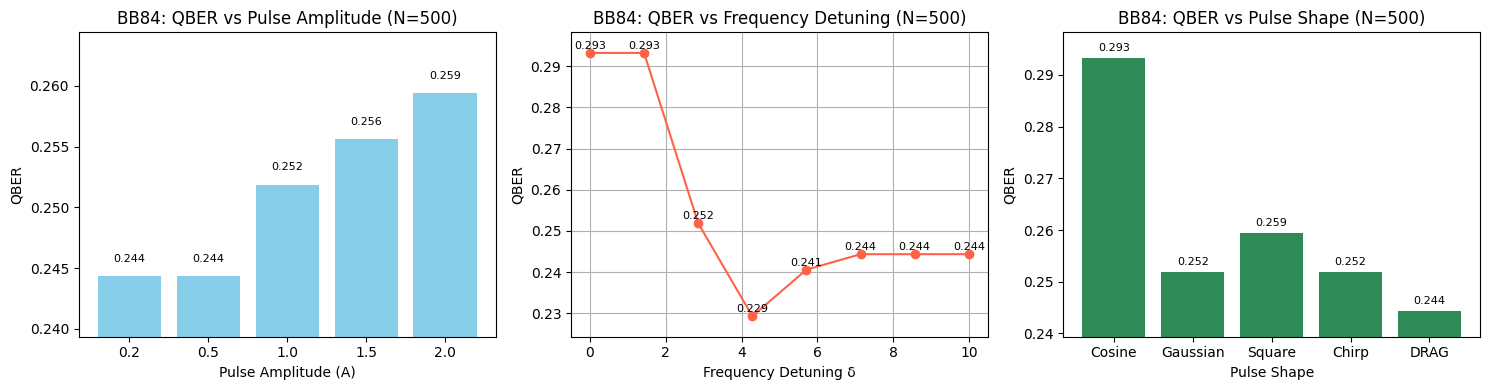

In [21]:
# Save as b92_pulse_params.py and run: python b92_pulse_params.py
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmay, sigmaz, qeye, mesolve

# -----------------------------
# Pauli operators
X = sigmax(); Y = sigmay(); Z = sigmaz(); I = qeye(2)

# Time evolution setup
n_steps = 50
tlist = np.linspace(0, 1, n_steps)

# Crosstalk couplings
J01, J12 = 1.0, 1.0

# -----------------------------
# BB84 states on Alice’s qubit (q2)
state_0 = basis(2, 0)  # |0>
state_1 = basis(2, 1)  # |1>
state_plus = (basis(2, 0) + basis(2, 1)).unit()   # |+>
state_minus = (basis(2, 0) - basis(2, 1)).unit()  # |->

# Projectors for Z and X basis
P0 = state_0 * state_0.dag()
P1 = state_1 * state_1.dag()
Pplus = state_plus * state_plus.dag()
Pminus = state_minus * state_minus.dag()


# -----------------------------
# Pulse shapes
def pulse_cosine(t, A=1.0, delta=0.0, **kwargs):
    return A * np.cos(delta * t)

def pulse_gaussian(t, A=1.0, sigma=0.08, **kwargs):
    return A * np.exp(-((t-0.5)**2) / (2*sigma**2))

def pulse_square(t, A=1.0, **kwargs):
    return A if 0.3 <= t <= 0.7 else 0.0

def pulse_chirp(t, A=1.0, delta=0.0, c=5.0, **kwargs):
    return A * np.cos((delta + c*t) * t)

def pulse_drag(t, A=1.0, sigma=0.08, alpha=2.0, **kwargs):
    return A * np.exp(-((t-0.5)**2) / (2*sigma**2) - alpha*((t-0.5)**2)/(sigma**2))

pulse_shapes = {
    "Cosine": pulse_cosine,
    "Gaussian": pulse_gaussian,
    "Square": pulse_square,
    "Chirp": pulse_chirp,
    "DRAG": pulse_drag
}

# -----------------------------
def evolve_three_qubit(state_q2, pulse_func, A=1.0, delta=0.0):
    """Evolve Alice’s B92 state under Eve’s pulse-level crosstalk attack."""
    # Couplings: Y⊗X on q0,q1 and Z⊗X on q1,q2
    H_coup_01 = tensor(Y, X, I)
    H_coup_12 = tensor(I, Z, X)

    # Drives (time-dependent)
    H_drive_0 = [tensor(X, I, I), lambda t, args: pulse_func(t, A=A, delta=delta)]
    H_drive_1 = [tensor(I, X, I), lambda t, args: pulse_func(t, A=A, delta=delta)]

    H = [J01*H_coup_01 + J12*H_coup_12, H_drive_0, H_drive_1]

    psi0 = tensor(basis(2,0), basis(2,0), state_q2)
    result = mesolve(H, psi0, tlist, [], [])
    return result.states[-1].ptrace(2)

def measure_bb84(rho, basis_choice):
    """Bob measures in Z or X basis."""
    if basis_choice == 0:  # Z basis
        p0 = np.real((P0 * rho).tr())
        return 0 if random.random() < p0 else 1
    else:  # X basis
        pplus = np.real((Pplus * rho).tr())
        return 0 if random.random() < pplus else 1

def run_bb84(N=500, pulse_func=pulse_gaussian, A=1.0, delta=0.0, seed=42):
    random.seed(seed)
    alice_bits, alice_bases, bob_bases, bob_results = [], [], [], []

    for _ in range(N):
        bit = random.randint(0, 1)
        basis = random.randint(0, 1)  # 0 = Z, 1 = X
        # Prepare state based on basis & bit
        if basis == 0:
            state = state_0 if bit == 0 else state_1
        else:
            state = state_plus if bit == 0 else state_minus

        alice_bits.append(bit)
        alice_bases.append(basis)

        # Crosstalk evolution
        rho_q2 = evolve_three_qubit(state, pulse_func, A=A, delta=delta)

        # Bob chooses measurement basis randomly
        bob_basis = random.randint(0, 1)
        bob_bases.append(bob_basis)
        bob_results.append(measure_bb84(rho_q2, bob_basis))

    # Sifting: keep only when Alice and Bob used the same basis
    sift_a, sift_b = [], []
    for i in range(N):
        if alice_bases[i] == bob_bases[i]:
            sift_a.append(alice_bits[i])
            sift_b.append(bob_results[i])

    mismatches = sum(a != b for a, b in zip(sift_a, sift_b))
    qber = mismatches / len(sift_a) if sift_a else 0.0
    return qber

# -----------------------------
# 1. QBER vs Pulse Amplitude
A_values = [0.2, 0.5, 1.0, 1.5, 2.0]
qber_vs_amp = [run_bb84(N=500, pulse_func=pulse_gaussian, A=A) for A in A_values]

# 2. QBER vs Frequency Detuning
delta_values = np.linspace(0, 10, 8)
qber_vs_delta = [run_bb84(N=500, pulse_func=pulse_cosine, delta=d) for d in delta_values]

# 3. QBER vs Pulse Shape
qber_vs_shape = {name: run_bb84(N=500, pulse_func=func) for name,func in pulse_shapes.items()}

# -----------------------------
# Plotting (same style as BB84)
plt.figure(figsize=(15,4))

# QBER vs Amplitude
plt.subplot(1,3,1)
bars = plt.bar([str(a) for a in A_values], qber_vs_amp, color="skyblue")
plt.xlabel("Pulse Amplitude (A)")
plt.ylabel("QBER")
plt.title("BB84: QBER vs Pulse Amplitude (N=500)")
plt.ylim(min(qber_vs_amp)-0.005, max(qber_vs_amp)+0.005)
for bar, val in zip(bars, qber_vs_amp):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.001,
             f"{val:.3f}", ha='center', va='bottom', fontsize=8)

# QBER vs Frequency Detuning
plt.subplot(1,3,2)
plt.plot(delta_values, qber_vs_delta, marker='o', color="tomato")
plt.xlabel("Frequency Detuning δ")
plt.ylabel("QBER")
plt.title("BB84: QBER vs Frequency Detuning (N=500)")
plt.ylim(min(qber_vs_delta)-0.005, max(qber_vs_delta)+0.005)
for x,y in zip(delta_values, qber_vs_delta):
    plt.text(x, y+0.001, f"{y:.3f}", ha='center', fontsize=8)
plt.grid(True)

# QBER vs Pulse Shape
plt.subplot(1,3,3)
bars = plt.bar(list(qber_vs_shape.keys()), list(qber_vs_shape.values()), color="seagreen")
plt.xlabel("Pulse Shape")
plt.ylabel("QBER")
plt.title("BB84: QBER vs Pulse Shape (N=500)")
plt.ylim(min(qber_vs_shape.values())-0.005, max(qber_vs_shape.values())+0.005)
for bar, val in zip(bars, qber_vs_shape.values()):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.001,
             f"{val:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


**Here we implemented a pulse-level crosstalk attack simulation against the entabgled based GHZ QKD experiment as it models multi-party entanglement tampering at pulse level.**

c:\Users\USER\anaconda3\envs\qkd-crosstalk\lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


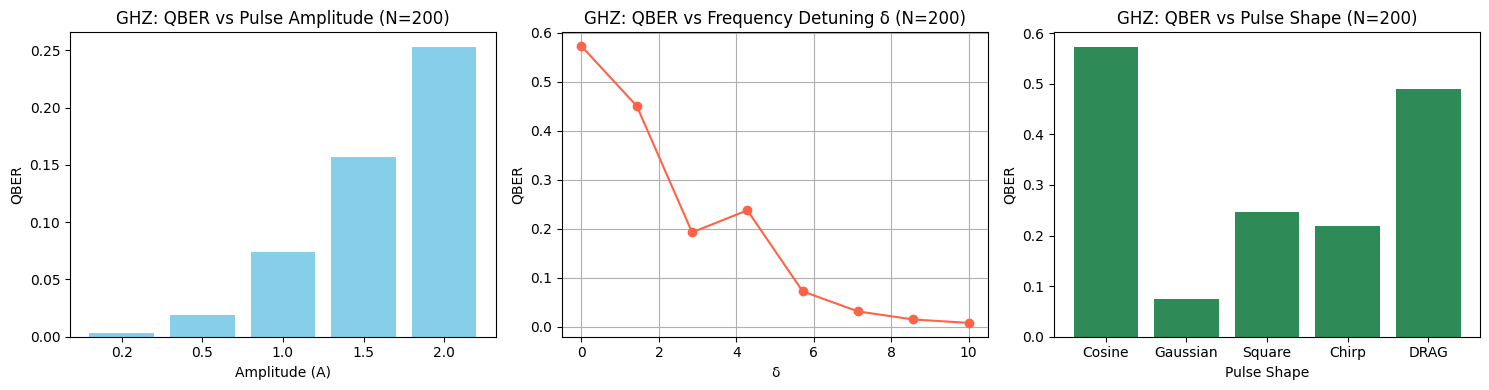

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmay, sigmaz, qeye, mesolve

# -----------------------------
# Pauli operators
X = sigmax(); Y = sigmay(); Z = sigmaz(); I = qeye(2)

# -----------------------------
# Time setup
n_steps = 50
tlist = np.linspace(0, 1, n_steps)
J01, J12 = 1.0, 1.0  # coupling strengths

# -----------------------------
# Pulse shapes (same as before)
def pulse_cosine(t, A=1.0, delta=0.0, **kwargs):
    return A * np.cos(delta * t)

def pulse_gaussian(t, A=1.0, sigma=0.08, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

def pulse_square(t, A=1.0, **kwargs):
    return A if 0.3 < t <= 0.7 else 0.0

def pulse_chirp(t, A=1.0, delta=0.0, c=5.0, **kwargs):
    return A * np.cos((delta + c*t) * t)

def pulse_drag(t, A=1.0, sigma=0.08, alpha=2.0, **kwargs):
    return A * np.exp(-((t - 0.5)**2) / (2 * sigma**2)) - alpha * ((t - 0.5)**2) / (sigma**2)

pulse_shapes = {
    "Cosine": pulse_cosine,
    "Gaussian": pulse_gaussian,
    "Square": pulse_square,
    "Chirp": pulse_chirp,
    "DRAG": pulse_drag
}

# -----------------------------
# GHZ state: |000> + |111>
state_000 = tensor(basis(2,0), basis(2,0), basis(2,0))
state_111 = tensor(basis(2,1), basis(2,1), basis(2,1))
psi_GHZ = (state_000 + state_111).unit()

# Measurement projectors
P0 = basis(2,0)*basis(2,0).dag()
P1 = basis(2,1)*basis(2,1).dag()

# -----------------------------
def evolve_ghz_state(pulse_func, A=1.0, delta=0.0):
    """Evolve GHZ state under Eve’s pulse injection on q0,q1 (crosstalk attack)."""
    H_coup_01 = tensor(Y, X, I)
    H_coup_12 = tensor(I, Z, X)
    H_drive_0 = [tensor(X, I, I), lambda t, args: pulse_func(t, A=A, delta=delta)]
    H_drive_1 = [tensor(I, X, I), lambda t, args: pulse_func(t, A=A, delta=delta)]

    H = [J01*H_coup_01 + J12*H_coup_12, H_drive_0, H_drive_1]

    result = mesolve(H, psi_GHZ, tlist, [], [])
    return result.states[-1]

# -----------------------------
def measure_ghz(rho):
    """Simulate Alice & Bob measuring in Z basis. Return bit pairs and mismatch rate."""
    # partial trace: get reduced density matrices
    rho_A = rho.ptrace(0)
    rho_B = rho.ptrace(1)

    # probabilities
    p00 = np.real((tensor(P0,P0) * rho.ptrace([0,1])).tr())
    p11 = np.real((tensor(P1,P1) * rho.ptrace([0,1])).tr())
    p_diff = 1 - (p00 + p11)
    return p_diff  # this acts like QBER

# -----------------------------
# Run GHZ experiment
def run_ghz(N=200, pulse_func=pulse_gaussian, A=1.0, delta=0.0):
    qbers = []
    for _ in range(N):
        rho_final = evolve_ghz_state(pulse_func, A=A, delta=delta)
        qber = measure_ghz(rho_final)
        qbers.append(qber)
    return np.mean(qbers)

# -----------------------------
# Parameter sweeps
A_values = [0.2, 0.5, 1.0, 1.5, 2.0]
delta_values = np.linspace(0, 10, 8)
qber_vs_shape = {name: run_ghz(pulse_func=func) for name, func in pulse_shapes.items()}

qber_vs_amp = [run_ghz(pulse_func=pulse_gaussian, A=A) for A in A_values]
qber_vs_delta = [run_ghz(pulse_func=pulse_cosine, delta=d) for d in delta_values]

# -----------------------------
# Plot results
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.bar([str(a) for a in A_values], qber_vs_amp, color="skyblue")
plt.title("GHZ: QBER vs Pulse Amplitude (N=200)")
plt.xlabel("Amplitude (A)"); plt.ylabel("QBER")

plt.subplot(1,3,2)
plt.plot(delta_values, qber_vs_delta, 'o-', color="tomato")
plt.title("GHZ: QBER vs Frequency Detuning δ (N=200)")
plt.xlabel("δ"); plt.ylabel("QBER"); plt.grid(True)

plt.subplot(1,3,3)
plt.bar(list(qber_vs_shape.keys()), list(qber_vs_shape.values()), color="seagreen")
plt.title("GHZ: QBER vs Pulse Shape (N=200)")
plt.xlabel("Pulse Shape"); plt.ylabel("QBER")

plt.tight_layout()
plt.show()

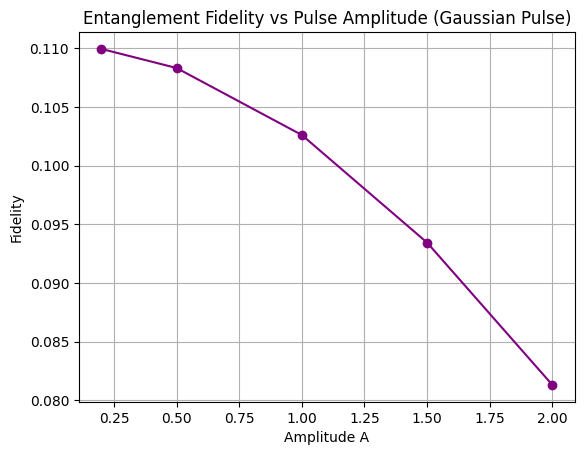

In [5]:
A_values = [0.2, 0.5, 1.0, 1.5, 2.0]

def fidelity_to_ghz(rho):
    """Compute fidelity between evolved GHZ and ideal GHZ."""
    return np.real((psi_GHZ.dag() * rho * psi_GHZ)[0, 0])

F_values = [fidelity_to_ghz(evolve_ghz_state(pulse_shapes['Gaussian'], A=a)) for a in A_values]

plt.plot(A_values, F_values, 'o-', color='purple')
plt.title("Entanglement Fidelity vs Pulse Amplitude (Gaussian Pulse)")
plt.xlabel("Amplitude A")
plt.ylabel("Fidelity")
plt.grid(True)
plt.show()